In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

This notebook uses latest ADAM optimizer.

In [2]:
import os
import shutil
import time
import datetime
import random

import numpy as np

from tensorflow.keras import layers,models,utils,optimizers
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import TensorBoard,EarlyStopping,LearningRateScheduler
from util.custom_callbacks import SkipLoggerCallback,StepDecayHistoryCallback
from util.custom_callbacks import step_decay

from util.learningratefinder import LearningRateFinder

import matplotlib.pyplot as plt

In [3]:
DATA_DIR = 'data/caps_and_shoes_squared/'
IMAGE_SIZE = (28,28)
CLASS_LIST = ['cap','shoes']
BATCH_SIZE = 32

train_path = DATA_DIR + 'train'
validation_path = DATA_DIR + 'val'
test_path = DATA_DIR + 'test'

SOURCE_DATA_DIR = 'data/caps_and_shoes_squared_2/'
TEST_DATA_DIR = 'data/out_of_set_tests/'

In [4]:
def create_test_set(seed=random.randint(1,10000)):

    dirpath = os.path.join(TEST_DATA_DIR, 'temp_test')
    if os.path.exists(dirpath) and os.path.isdir(dirpath):
        shutil.rmtree(dirpath)
        
    os.makedirs(dirpath, exist_ok=True)
    
    for class_name in CLASS_LIST:
        src_dir = os.path.join(SOURCE_DATA_DIR, class_name)
        dest_dir = os.path.join(dirpath, class_name)
        os.makedirs(dest_dir, exist_ok=True)
        
        src_files = (os.listdir(src_dir))
        random.seed(seed)
        choices = random.sample(src_files, 25)
        for file_name in choices:
            shutil.copy(os.path.join(src_dir, file_name), dest_dir)
            
def get_oos_test_accuracy(model=None):
    
    out_test_accuracy_log = []
    
    for iter_count in range(25):
    
        seed = random.randint(1,10000)
        create_test_set(seed)

        test_img_generator = ImageDataGenerator(rescale = 1./255)
        test_batches = test_img_generator.flow_from_directory(os.path.join(TEST_DATA_DIR, 'temp_test'),
                                                              target_size=IMAGE_SIZE, classes=CLASS_LIST, color_mode = 'grayscale', 
                                                              class_mode = 'categorical', batch_size=32)
        test_loss, test_accuracy = model.evaluate_generator(test_batches, workers=4, verbose=0) 
        out_test_accuracy_log.append(test_accuracy)
    
    return (np.mean(out_test_accuracy_log),np.std(out_test_accuracy_log))

In [5]:
test_img_generator = ImageDataGenerator( rescale = 1./255)
train_validation_img_generator = ImageDataGenerator(validation_split=0.2, rescale = 1./255, rotation_range = 10, width_shift_range = 0.1, height_shift_range=0.1, zoom_range = 0.1, 
                                   horizontal_flip=True, fill_mode='nearest')

train_batches = train_validation_img_generator.flow_from_directory(train_path, target_size=IMAGE_SIZE, classes=CLASS_LIST, color_mode = 'grayscale', 
                                                  class_mode = 'categorical', batch_size=BATCH_SIZE, subset='training')

validation_batches = train_validation_img_generator.flow_from_directory(train_path, target_size=IMAGE_SIZE, classes=CLASS_LIST, color_mode = 'grayscale', 
                                                  class_mode = 'categorical', batch_size=BATCH_SIZE, subset='validation')

test_batches = test_img_generator.flow_from_directory(test_path, target_size=IMAGE_SIZE, classes=CLASS_LIST, color_mode = 'grayscale', 
                                                  class_mode = 'categorical',batch_size=1, shuffle=False)

Found 1832 images belonging to 2 classes.
Found 457 images belonging to 2 classes.
Found 326 images belonging to 2 classes.


In [7]:
def define_model_architecture_64_32_16(optimizer_p = 'sgd'):
    model = models.Sequential()
    model.add(Flatten(input_shape = (28,28,1)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    
    model.compile(optimizer=optimizer_p, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [8]:
adam = optimizers.Adam()
model = define_model_architecture_64_32_16(optimizer_p=adam)

In [13]:
lrf = LearningRateFinder(model)
lrf.find(train_batches,1e-10, 1e+1, stepsPerEpoch=train_batches.samples/BATCH_SIZE, batchSize=BATCH_SIZE, verbose=0)

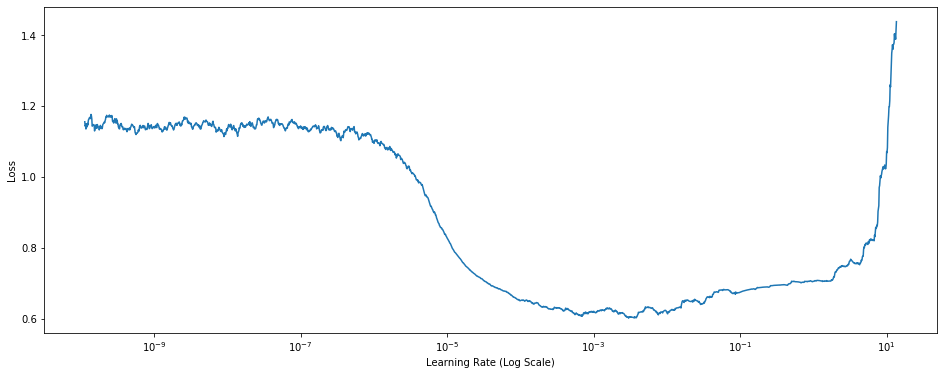

In [14]:
lrf.plot_loss()

Optimum rate is from 1e-6 to 1e-3

In [17]:
learning_rates = [1e-6,1e-5,1e-4,1e-3]
learning_history_dict = {}
training_time_dict = {}
out_of_set_test_dict = {}
EPOCHS = 500

In [18]:
!rm -rf ./logs/
skipLogger_callback = SkipLoggerCallback(n=25)

In [19]:
for learning_rate in learning_rates:
    print('working with learning rate : %f' % learning_rate)
    print('')
    
    adam = optimizers.Adam(lr=learning_rate)
    model = define_model_architecture_64_32_16(optimizer_p=adam)
    
    log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tb_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
    
    start = time.time()
    history = model.fit_generator(generator = train_batches, steps_per_epoch=train_batches.samples/BATCH_SIZE, 
                                  validation_data = validation_batches, validation_steps = validation_batches.samples/BATCH_SIZE, 
                                  epochs=EPOCHS, verbose=0, workers=4, callbacks = [skipLogger_callback, tb_callback])
    training_time_dict[str(learning_rate)] = time.time() - start
    learning_history_dict[str(learning_rate)] = history
    
    out_of_set_test_dict[str(learning_rate)] = get_oos_test_accuracy(model)
    test_loss, test_accuracy = model.evaluate_generator(test_batches, workers=4, verbose=0) 
    print('Test loss: %.4f accuracy: %.4f' % (test_loss, test_accuracy))    
    print('-'*120)


working with learning rate : 0.000001

epoch =    0    loss = 0.871087    accuracy = 0.49    val_loss = 0.917108    val_accuracy = 0.49
epoch =   25    loss = 0.687941    accuracy = 0.50    val_loss = 0.726307    val_accuracy = 0.50
epoch =   50    loss = 0.665289    accuracy = 0.60    val_loss = 0.700641    val_accuracy = 0.60
epoch =   75    loss = 0.655300    accuracy = 0.63    val_loss = 0.683292    val_accuracy = 0.61
epoch =  100    loss = 0.648542    accuracy = 0.64    val_loss = 0.691457    val_accuracy = 0.59
epoch =  125    loss = 0.643978    accuracy = 0.66    val_loss = 0.676142    val_accuracy = 0.62
epoch =  150    loss = 0.638289    accuracy = 0.67    val_loss = 0.680211    val_accuracy = 0.62
epoch =  175    loss = 0.633899    accuracy = 0.66    val_loss = 0.672008    val_accuracy = 0.63
epoch =  200    loss = 0.626220    accuracy = 0.68    val_loss = 0.677383    val_accuracy = 0.62
epoch =  225    loss = 0.625134    accuracy = 0.69    val_loss = 0.665269    val_accurac

Found 50 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 49 images belonging to 2 classes.
Found 49 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


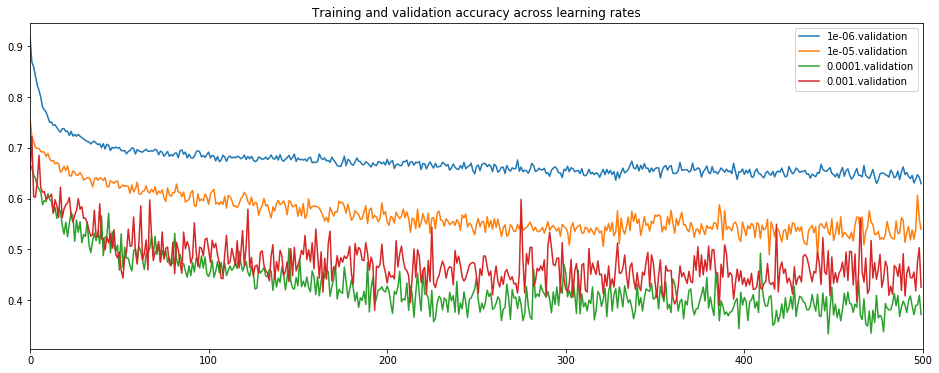

In [21]:
plt.figure(num=None, figsize=(16, 6))

for lr,training_history in learning_history_dict.items():
    #plt.plot(training_history.history['loss'], label= lr +'.train')
    plt.plot(training_history.history['val_loss'], label= lr + '.validation')

plt.legend()
plt.title('Training and validation accuracy across learning rates')
plt.xlim(0, EPOCHS)
plt.show()

### Finetuning by range finder

In [22]:
adam = optimizers.Adam()
model = define_model_architecture_64_32_16(optimizer_p=adam)

In [31]:
lrf = LearningRateFinder(model)
lrf.find(train_batches,8e-5, 8e-4, stepsPerEpoch=train_batches.samples/BATCH_SIZE, batchSize=BATCH_SIZE, verbose=0)

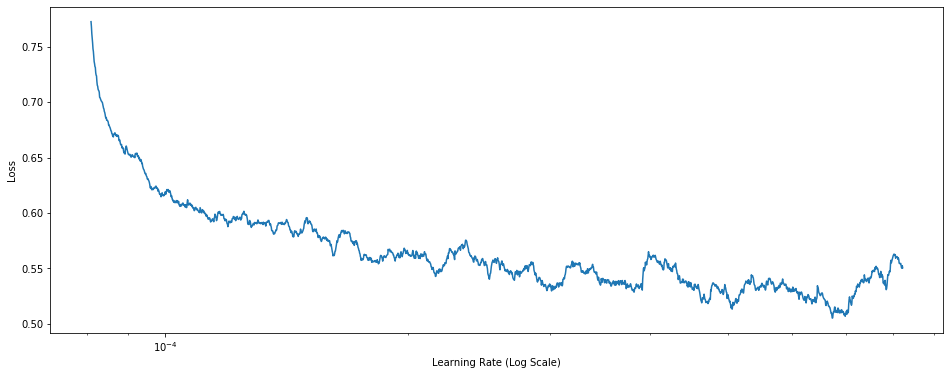

In [32]:
lrf.plot_loss()

In [9]:
learning_rates = [7e-5,9.8e-5,1e-4,6e-4]
learning_history_dict = {}
training_time_dict = {}
out_of_set_test_dict = {}
EPOCHS = 300

In [10]:
!rm -rf ./logs/
skipLogger_callback = SkipLoggerCallback(n=25)

In [11]:
for learning_rate in learning_rates:
    print('working with learning rate : %f' % learning_rate)
    print('')
    
    adam = optimizers.Adam(lr=learning_rate)
    model = define_model_architecture_64_32_16(optimizer_p=adam)
    
    log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tb_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
    
    start = time.time()
    history = model.fit_generator(generator = train_batches, steps_per_epoch=train_batches.samples/BATCH_SIZE, 
                                  validation_data = validation_batches, validation_steps = validation_batches.samples/BATCH_SIZE, 
                                  epochs=EPOCHS, verbose=0, workers=4, callbacks = [skipLogger_callback, tb_callback])
    training_time_dict[str(learning_rate)] = time.time() - start
    learning_history_dict[str(learning_rate)] = history
    
    out_of_set_test_dict[str(learning_rate)] = get_oos_test_accuracy(model)
    test_loss, test_accuracy = model.evaluate_generator(test_batches, workers=4, verbose=0) 
    print('Test loss: %.4f accuracy: %.4f' % (test_loss, test_accuracy))    
    print('-'*120)


working with learning rate : 0.000070



W0905 19:12:25.944682 139930065200960 deprecation.py:323] From /home/algolaptop8/anaconda3/envs/tf2-env/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


epoch =    0    loss = 0.685931    accuracy = 0.55    val_loss = 0.702870    val_accuracy = 0.61
epoch =   25    loss = 0.537939    accuracy = 0.73    val_loss = 0.571201    val_accuracy = 0.72
epoch =   50    loss = 0.494562    accuracy = 0.77    val_loss = 0.506387    val_accuracy = 0.77
epoch =   75    loss = 0.467206    accuracy = 0.79    val_loss = 0.512407    val_accuracy = 0.80
epoch =  100    loss = 0.444051    accuracy = 0.81    val_loss = 0.472387    val_accuracy = 0.81
epoch =  125    loss = 0.432329    accuracy = 0.82    val_loss = 0.459701    val_accuracy = 0.80
epoch =  150    loss = 0.416346    accuracy = 0.83    val_loss = 0.460406    val_accuracy = 0.77
epoch =  175    loss = 0.396436    accuracy = 0.83    val_loss = 0.445244    val_accuracy = 0.82
epoch =  200    loss = 0.396976    accuracy = 0.83    val_loss = 0.456929    val_accuracy = 0.80
epoch =  225    loss = 0.393920    accuracy = 0.83    val_loss = 0.441973    val_accuracy = 0.82
epoch =  250    loss = 0.37316

Found 50 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 49 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 48 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 49 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 49 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 48 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 49 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 49 images belonging to 2 classes.
Found 49 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 49 images belonging to 2 classes.


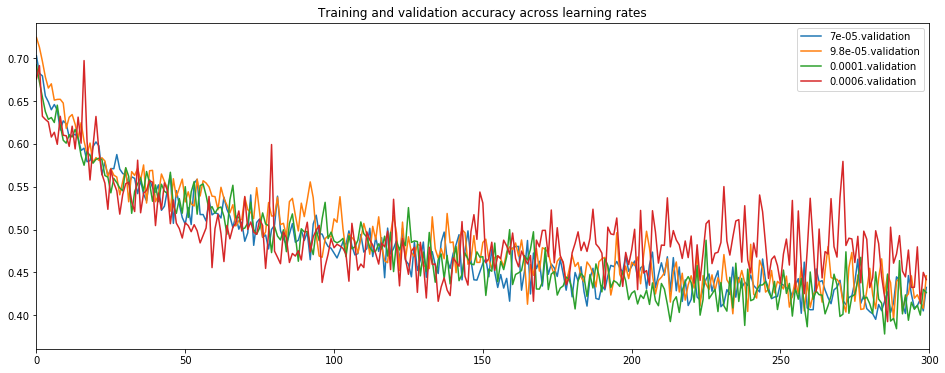

In [12]:
plt.figure(num=None, figsize=(16, 6))

for lr,training_history in learning_history_dict.items():
    #plt.plot(training_history.history['loss'], label= lr +'.train')
    plt.plot(training_history.history['val_loss'], label= lr + '.validation')

plt.legend()
plt.title('Training and validation accuracy across learning rates')
plt.xlim(0, EPOCHS)
plt.show()

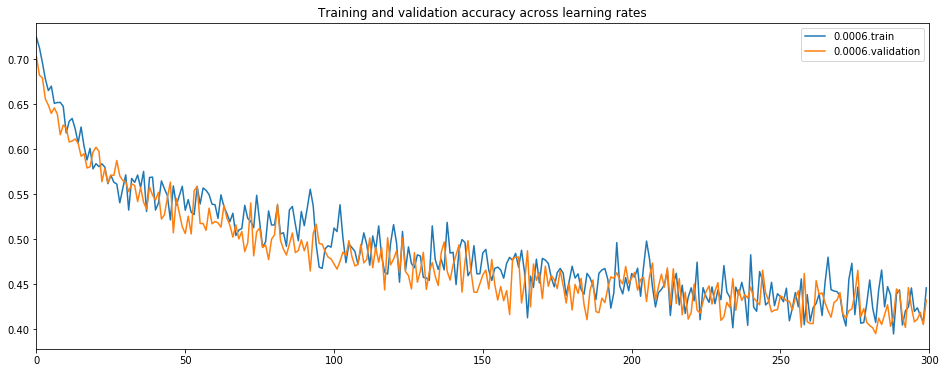

In [23]:
plt.figure(num=None, figsize=(16, 6))

plt.plot(learning_history_dict['9.8e-05'].history['val_loss'], label= lr +'.train')
plt.plot(learning_history_dict['7e-05'].history['val_loss'], label= lr + '.validation')

plt.legend()
plt.title('Training and validation accuracy across learning rates')
plt.xlim(0, EPOCHS)
plt.show()

In [13]:
out_of_set_test_dict

{'7e-05': (0.8328163, 0.045354273),
 '9.8e-05': (0.83366364, 0.062365796),
 '0.0001': (0.8305633, 0.05487188),
 '0.0006': (0.84185106, 0.052316993)}

In [14]:
training_time_dict

{'7e-05': 1758.9357845783234,
 '9.8e-05': 1730.0522265434265,
 '0.0001': 1710.0321207046509,
 '0.0006': 1704.131941318512}

### Learning schedule

Start with learning rate of 7e-4 for 150 epochs then 7e-5 for 250 epochs and then 9e-5 for 200 epochs

In [33]:
def custom_decay(epoch):
    if epoch < 50 :
        lrate = 1e-3
    elif epoch < 250 :
        lrate = 7e-4
    elif epoch < 450 :
        lrate = 7e-5
    else:
        lrate =  9e-5
        
    return lrate

In [35]:
EPOCHS = 600

In [36]:
!rm -rf ./logs/
skipLogger_callback = SkipLoggerCallback(n=25)

lrate_callback = LearningRateScheduler(custom_decay)

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

callback_list = [skipLogger_callback,lrate_callback,tb_callback]

In [37]:
adam = optimizers.Adam(lr=0.0)
model = define_model_architecture_64_32_16(optimizer_p=adam)
    
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
    
start = time.time()
history = model.fit_generator(generator = train_batches, steps_per_epoch=train_batches.samples/BATCH_SIZE, 
                              validation_data = validation_batches, validation_steps = validation_batches.samples/BATCH_SIZE, 
                              epochs=EPOCHS, verbose=0, workers=4, callbacks = callback_list)

print('time taken : %.4f' % (time.time() - start))
oos_test_loss, oos_test_accuracy = get_oos_test_accuracy(model)
print('OOS Test loss: %.4f OOS accuracy: %.4f' % (oos_test_loss, oos_test_accuracy))    
test_loss, test_accuracy = model.evaluate_generator(test_batches, workers=4, verbose=0) 
print('Test loss: %.4f accuracy: %.4f' % (test_loss, test_accuracy))    

print('-'*120)

epoch =    0    loss = 0.674422    accuracy = 0.61    val_loss = 0.666734    val_accuracy = 0.67
epoch =   25    loss = 0.523673    accuracy = 0.74    val_loss = 0.570902    val_accuracy = 0.71
epoch =   50    loss = 0.469977    accuracy = 0.78    val_loss = 0.503500    val_accuracy = 0.79
epoch =   75    loss = 0.442688    accuracy = 0.79    val_loss = 0.498824    val_accuracy = 0.82
epoch =  100    loss = 0.407092    accuracy = 0.82    val_loss = 0.504817    val_accuracy = 0.79
epoch =  125    loss = 0.407319    accuracy = 0.82    val_loss = 0.460402    val_accuracy = 0.81
epoch =  150    loss = 0.400391    accuracy = 0.83    val_loss = 0.537006    val_accuracy = 0.79
epoch =  175    loss = 0.374307    accuracy = 0.84    val_loss = 0.520191    val_accuracy = 0.76
epoch =  200    loss = 0.361804    accuracy = 0.84    val_loss = 0.437499    val_accuracy = 0.83
epoch =  225    loss = 0.372003    accuracy = 0.83    val_loss = 0.428874    val_accuracy = 0.81
epoch =  250    loss = 0.32942

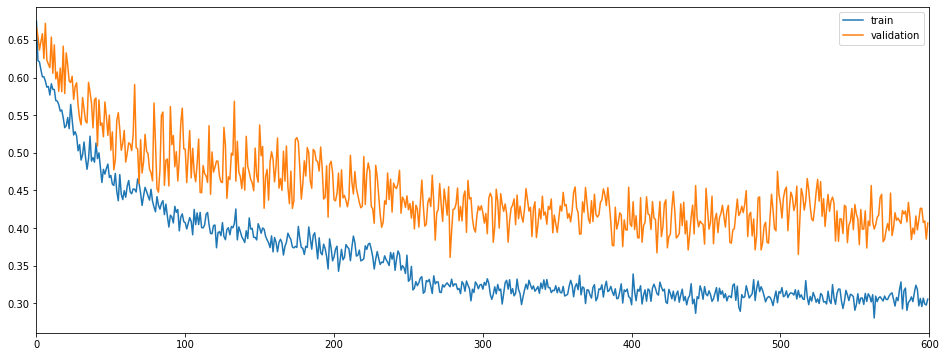

In [38]:
plt.figure(figsize=(16, 6))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.xlim(0, EPOCHS)
plt.show()

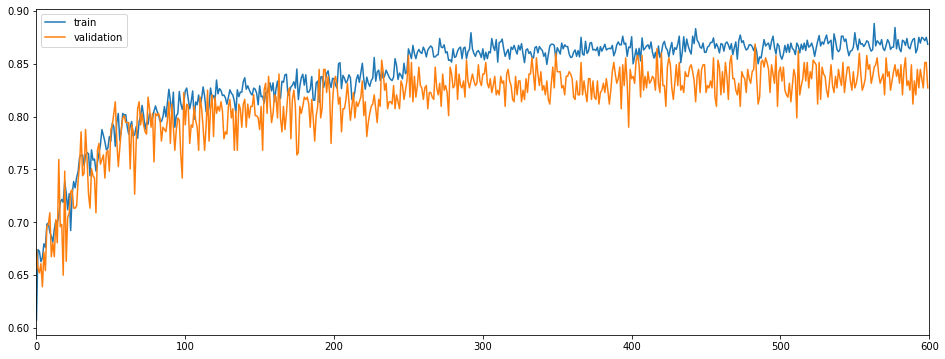

In [39]:
plt.figure(figsize=(16, 6))
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.xlim(0, EPOCHS)
plt.show()